# Practical Data Munging

In [1]:
library("tidyverse")
library("readxl")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Objective

Suppose we want to visualize the change in deaths of PWH over time for transmission risk factors.

## Get data and try to understand it

In [2]:
df<- read_excel('deaths-of-persons-diagnosed-with-hiv-aids.xlsx')

In [3]:
df  %>% dim

[1] 215   4

In [4]:
df %>% head(2)

Year,Category,Group,Count
2011,Age at Death,0-11,0
2011,Age at Death,12-14,0


In [5]:
df %>% tail(2)

Year,Category,Group,Count
2015,Transmission Category: Female Adult or Adolescent,Other****,3
2015,Transmission Category: Child (<12 Years Old at the End of Year),Perinatal,0


In [6]:
df  %>% summary

      Year        Category            Group               Count       
 Min.   :2011   Length:215         Length:215         Min.   :   0.0  
 1st Qu.:2012   Class :character   Class :character   1st Qu.:   2.0  
 Median :2013   Mode  :character   Mode  :character   Median :  48.0  
 Mean   :2013                                         Mean   : 155.3  
 3rd Qu.:2014                                         3rd Qu.: 206.0  
 Max.   :2015                                         Max.   :1464.0  

In [7]:
df %>% str

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	215 obs. of  4 variables:
 $ Year    : num  2011 2011 2011 2011 2011 ...
 $ Category: chr  "Age at Death" "Age at Death" "Age at Death" "Age at Death" ...
 $ Group   : chr  "0-11" "12-14" "15-17" "18-19" ...
 $ Count   : num  0 0 0 0 19 34 59 106 170 324 ...


## Pull out the transmission categories into separate data frames

In [8]:
df  %>% select(Category) %>% distinct

Category
Age at Death
Current Gender
Race/Ethnicity
Transmission Category: Male Adult or Adolescent
Transmission Category: Female Adult or Adolescent
Transmission Category: Child (<12 Years Old at the End of Year)


In [9]:
df %>%
filter(Category == "Transmission Category: Male Adult or Adolescent")  %>% 
select(Year, -Category, "Transmission Category: Male Adult or Adolescent"=Group, Count) -> df_male

In [10]:
df_male %>% head(3)

Year,Transmission Category: Male Adult or Adolescent,Count
2011,Male-to-male sexual contact (MSM),884
2011,Injection drug use (IDU),162
2011,MSM and IDU,237


In [11]:
df %>%
filter(Category == "Transmission Category: Female Adult or Adolescent")  %>% 
select(Year, -Category, "Transmission Category: Female Adult or Adolescent"=Group, Count) -> df_female

In [12]:
df_female %>% head(3)

Year,Transmission Category: Female Adult or Adolescent,Count
2011,Injection drug use (IDU),105
2011,High-risk heterosexual contact (HRH)***,89
2011,Heterosexual contact (Non-HRH),25


In [13]:
df %>%
filter(Category == "Transmission Category: Child (<12 Years Old at the End of Year)")  %>% 
select(Year, -Category, "Transmission Category: Child (<12 Years Old at the End of Year)"=Group, Count) -> df_child

## Combine the transmission categories

In [14]:
df_child %>% 
spread("Transmission Category: Child (<12 Years Old at the End of Year)", Count) %>% 
mutate(Category="Child") -> df_child_wide

In [15]:
df_female  %>% 
spread("Transmission Category: Female Adult or Adolescent", Count) %>%
mutate(Category="Female") -> df_female_wide

In [16]:
df_male  %>% 
distinct %>%
spread("Transmission Category: Male Adult or Adolescent", Count) %>% 
mutate(Category="Male") -> df_male_wide

In [17]:
bind_rows(df_male_wide, df_female_wide, df_male_wide) -> df_transmission

In [18]:
df_transmission %>% head(3)

Year,Heterosexual contact (Non-HRH)***,High-risk heterosexual contact (HRH)**,Injection drug use (IDU),Male-to-male sexual contact (MSM),MSM and IDU,Other****,Perinatal,Unknown risk,Category,Heterosexual contact (Non-HRH),High-risk heterosexual contact (HRH)***
2011,59,47,162,884,237,7,2,85,Male,NA,NA
2012,41,46,165,890,206,6,5,76,Male,NA,NA
2013,49,45,158,912,195,NA,2,55,Male,NA,NA


## Use `gather` to make the transmission data tidy

In [19]:
df_transmission %>% 
gather(Transmission, Count, -Year, -Category) %>% 
filter()  %>% 
na.omit(Count) -> df_transmission_tall

In [20]:
df_transmission_tall  %>% head

Year,Category,Transmission,Count
2011,Male,Heterosexual contact (Non-HRH)***,59
2012,Male,Heterosexual contact (Non-HRH)***,41
2013,Male,Heterosexual contact (Non-HRH)***,49
2014,Male,Heterosexual contact (Non-HRH)***,44
2015,Male,Heterosexual contact (Non-HRH)***,44
2013,Female,Heterosexual contact (Non-HRH)***,25


## Create a summary table

In [21]:
df_transmission_tall %>% 
group_by(Transmission) %>% 
summarize(Deaths=sum(Count))

Transmission,Deaths
Heterosexual contact (Non-HRH),86
Heterosexual contact (Non-HRH)***,527
High-risk heterosexual contact (HRH)**,626
High-risk heterosexual contact (HRH)***,265
Injection drug use (IDU),2027
Male-to-male sexual contact (MSM),9022
MSM and IDU,2158
Other****,59
Perinatal,31
Unknown risk,765


## Plot example 1

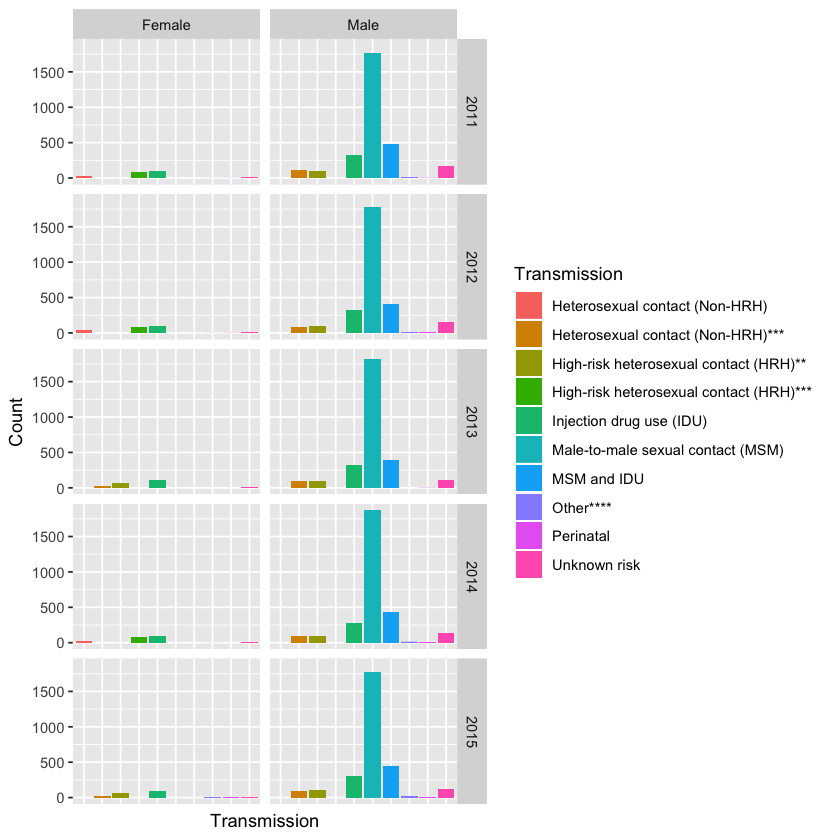

In [23]:
df_transmission_tall %>%
ggplot(aes(x=Transmission, y=Count, fill=Transmission)) +
facet_grid(Year ~ Category) +
geom_bar(stat='Identity') +
theme(axis.text.x=element_blank(),
      axis.ticks.x=element_blank())

## Plot example 2

In [24]:
df_transmission_tall %>%
ggplot(aes(x=Year, y=Count, fill=Transmission)) +
facet_wrap(~Transmission, ncol=1, scales="free_y") +
geom_point() +
# geom_bar(stat='Identity', position='dodge2') +
geom_smooth() +
guides(fill=FALSE) -> g

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


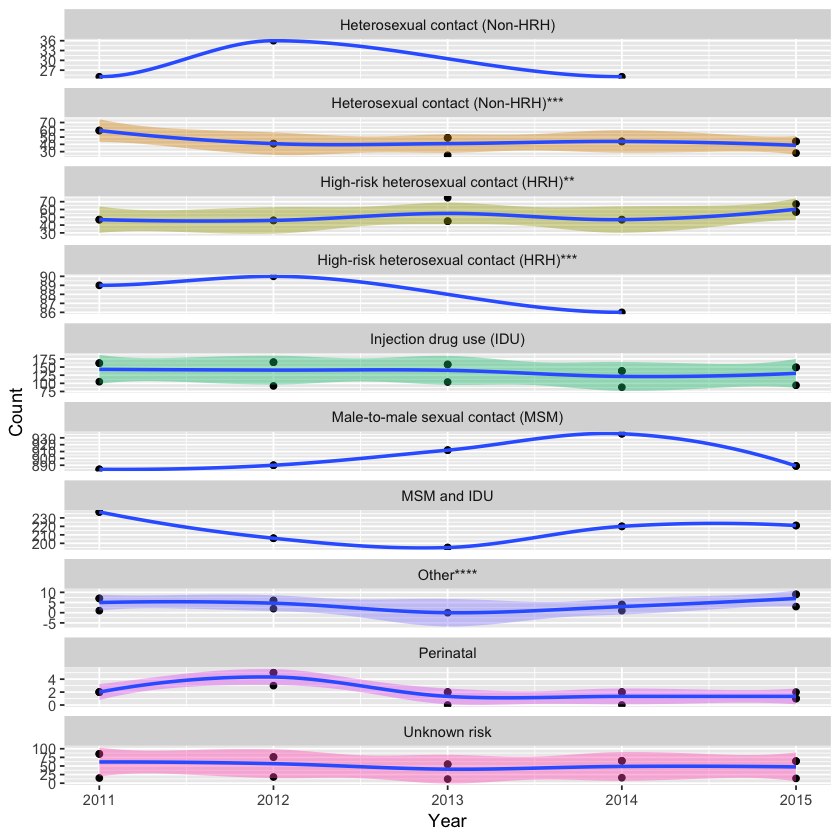

In [25]:
suppressWarnings(print(g))

## Exercises

**1**. Read the file `persons-living-with-hiv-aids.xlsx` into a data frame.

In [26]:
df<- read_excel('persons-living-with-hiv-aids.xlsx')

In [27]:
df %>% head(3)

Year,Category,Group,Count
2011,Age at Year End,0-11,164
2011,Age at Year End,12-14,86
2011,Age at Year End,15-17,176


**2**. How many rows and columns are there?

In [28]:
df %>% dim

[1] 225   4

**3**. Is the number of Asians with HIV growing over time? Do this using a bar plot.

In [29]:
df %>% 
select(Category) %>% 
distinct

Category
Age at Year End
Current Gender
Race/Ethnicity
Transmission Category: Male Adult or Adolescent
Transmission Category: Female Adult or Adolescent
Transmission Category: Child (<12 Years Old at the End of Year)


In [30]:
df %>% 
filter(Category == 'Race/Ethnicity') %>% 
select(Group) %>%
distinct

Group
American Indian/Alaska Native
Asian*
Black/African American
Hispanic/Latino*
Native Hawaiian/Pacific Islander
White
Multiple races
Unknown race
Asian**


In [31]:
df %>%
filter(Category == 'Race/Ethnicity', 
       str_detect(Group, 'Asian'))

Year,Category,Group,Count
2011,Race/Ethnicity,Asian*,3851
2012,Race/Ethnicity,Asian*,4138
2013,Race/Ethnicity,Asian*,4402
2014,Race/Ethnicity,Asian**,4705
2015,Race/Ethnicity,Asian*,4961


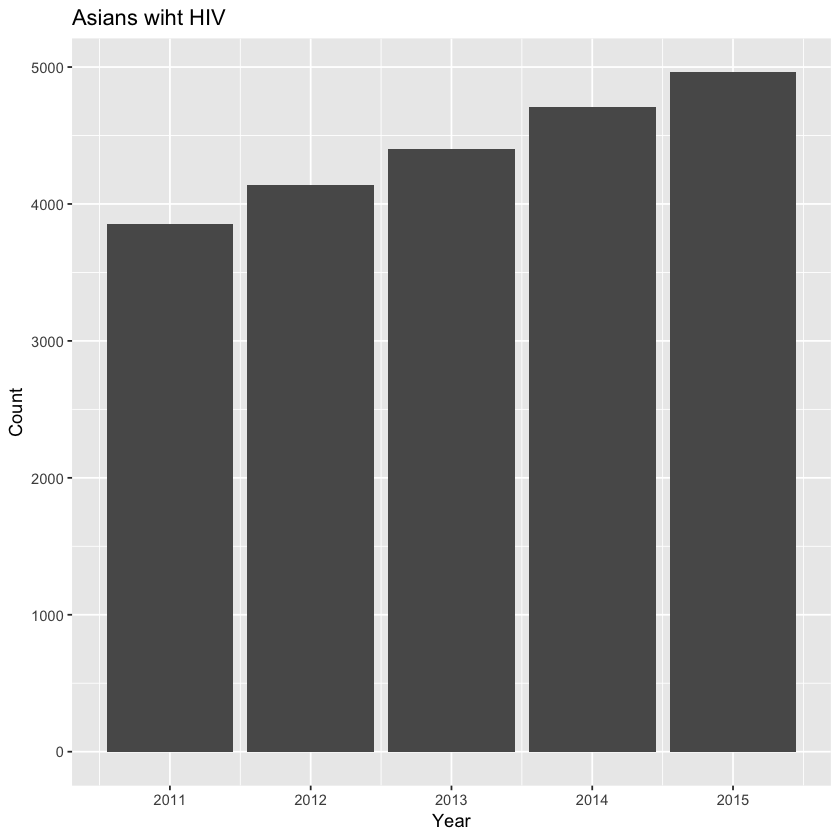

In [32]:
df %>%
filter(Category == 'Race/Ethnicity', 
       str_detect(Group, 'Asian'))  %>% 
ggplot(aes(x=Year, y=Count)) +
geom_bar(stat='Identity') +
labs(title="Asians wiht HIV")

**4**. Make a horizontal bar chart of the total number of PWH over all years for each ethnic group. There should be a single Asian group. The bar chart should display the names of each ethnic group on the y-axis, and the number of deaths on the x-axis, where the ethnic groups are ordered from fewest (top) to most (bottom) deaths.

In [34]:
df %>% 
mutate(Group = str_replace(Group, 'Asian.*', 'Asian')) %>% 
filter(Category == 'Race/Ethnicity') %>% 
group_by(Group) %>% 
summarize(Deaths=sum(Count)) %>% 
arrange(Deaths)

Group,Deaths
Unknown race,35
Native Hawaiian/Pacific Islander,1291
American Indian/Alaska Native,1986
Multiple races,13984
Asian,22057
Black/African American,109296
Hispanic/Latino*,206748
White,261574


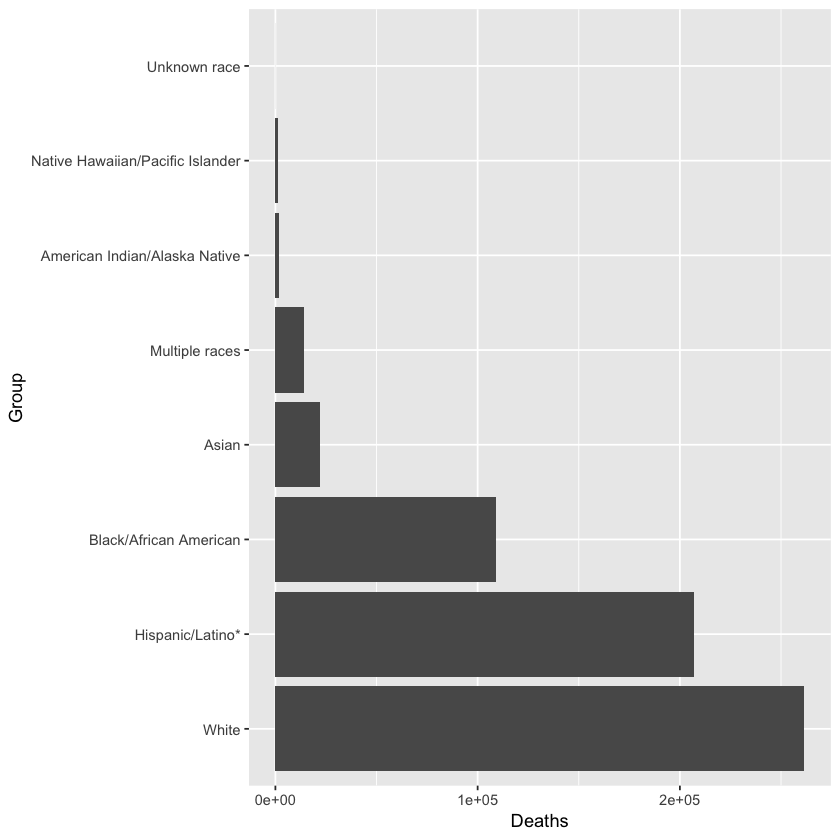

In [35]:
df %>% 
mutate(Group = str_replace(Group, 'Asian.*', 'Asian')) %>% 
filter(Category == 'Race/Ethnicity') %>% 
group_by(Group) %>% 
summarize(Deaths=sum(Count)) %>% 
arrange(desc(Deaths)) %>% 
mutate(Group=factor(Group, levels=Group)) %>% 
ggplot(aes(x=Group, y=Deaths)) +
geom_bar(stat='Identity') +
coord_flip()